Sources:

https://benmoseley.blog/my-research/so-what-is-a-physics-informed-neural-network/


https://www.kaggle.com/code/pengyangraul/harmonic-oscillator

# 1D harmonic oscillator physics-informed neural network (PINN)

This notebook contains the code to reproduce the plots presented in my blog post ["So, what is a physics-informed neural network?"](https://benmoseley.blog/my-research/so-what-is-a-physics-informed-neural-network/). 

Please read the post for more details!

## Problem overview

The example problem we solve here is the 1D damped harmonic oscillator:
$$
m \dfrac{d^2 x}{d t^2} + \mu \dfrac{d x}{d t} + kx = 0~,
$$
with the initial conditions
$$
x(0) = 1~~,~~\dfrac{d x}{d t} = 0~.
$$
We will focus on solving the problem for the under-damped state, i.e. when 
$$
\delta < \omega_0~,~~~~~\mathrm{with}~~\delta = \dfrac{\mu}{2m}~,~\omega_0 = \sqrt{\dfrac{k}{m}}~.
$$
This has the following exact solution:
$$
x(t) = e^{-\delta t}(2 A \cos(\phi + \omega t))~,~~~~~\mathrm{with}~~\omega=\sqrt{\omega_0^2 - \delta^2}~.
$$

This problem was inspired by the following blog post: https://beltoforion.de/en/harmonic_oscillator/.

```



In [1]:
import os, shutil

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from PIL import Image

In [2]:
def save_gif_PIL(outfile, files, fps=5, loop=0):
    "Helper function for saving GIFs"
    imgs = [Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format='GIF', append_images=imgs[1:], save_all=True, duration=int(1000/fps), loop=loop)
    
def oscillator(d, w0, x):
    """Defines the analytical solution to the 1D underdamped harmonic oscillator problem. 
    Equations taken from: https://beltoforion.de/en/harmonic_oscillator/"""
    assert d < w0
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi+w*x)
    sin = torch.sin(phi+w*x)
    exp = torch.exp(-d*x)
    y  = exp*2*A*cos
    return y


## Generate training data

> First, we generate some training data from a small part of the true analytical solution.

For this problem, we use $\delta=2$, $\omega_0=20$, and try to learn the solution over the domain $x\in [0,1]$.

torch.Size([500, 1]) torch.Size([500, 1])
torch.Size([10, 1]) torch.Size([10, 1])


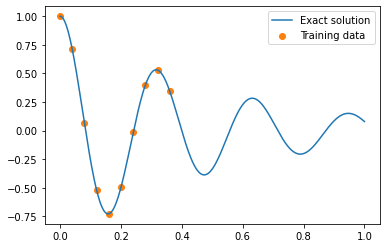

In [3]:
d, w0 = 2, 20

# get the analytical solution over the full domain
x = torch.linspace(0,1,500).view(-1,1)
y = oscillator(d, w0, x).view(-1,1)
print(x.shape, y.shape)

# slice out a small number of points from the LHS of the domain
x_data = x[0:200:20]
y_data = y[0:200:20]
print(x_data.shape, y_data.shape)

plt.figure()
plt.plot(x, y, label="Exact solution")
plt.scatter(x_data, y_data, color="tab:orange", label="Training data")
plt.legend()
plt.show()

In [4]:
class FullyConnected(nn.Module):
    "Defines a fully connected neural network"
    def __init__(self, layer_size, activation=nn.Tanh):
        super().__init__()
        layers = []
        
        for i in range(len(layer_size) - 2):
            layers.append(nn.Linear(layer_size[i], layer_size[i+1]))
            layers.append(activation())            
        
        self.layers = nn.Sequential(
            *layers,
            nn.Linear(layer_size[-2], layer_size[-1])
        )
        
    def forward(self, inpt):
        outpt = inpt
        for layer in self.layers:
            outpt = layer(outpt)
        return outpt

In [5]:
def plot_result(x,y,yh, i, xp=None):
    "Pretty plot training results"
    plt.figure(figsize=(8,4))
    plt.plot(x,y, color="grey", linewidth=2, alpha=0.8, label="Exact solution")
    plt.plot(x,yh, color="tab:blue", linewidth=4, alpha=0.8, label="Neural network prediction")
    if xp is not None:
        plt.scatter(xp, -0*torch.ones_like(xp), s=60, color="tab:green", alpha=0.4, 
                    label='Physics loss training locations')
    l = plt.legend(loc=(1.01,0.34), frameon=False, fontsize="large")
    plt.setp(l.get_texts(), color="k")
#     plt.xlim(-0.05, 1.05)
#     plt.ylim(-1.1, 1.1)
    plt.text(1.065,0.7,"Training step: %i"%(i+1),fontsize="xx-large",color="k")
    plt.axis("off")

## PINN

> Finally, we add the underlying differential equation ("physics loss") to the loss function. 

The physics loss aims to ensure that the learned solution is consistent with the underlying differential equation. This is done by penalising the residual of the differential equation over a set of locations sampled from the domain.

Here we evaluate the physics loss at 30 points uniformly spaced over the problem domain $([0,1])$. We can calculate the derivatives of the network solution with respect to its input variable at these points using `pytorch`'s autodifferentiation features, and can then easily compute the residual of the differential equation using these quantities.

In [6]:
import torch.nn as nn
def train_oscillator(physics_weight):
    x = torch.linspace(0,1,500).view(-1,1)
    y = oscillator(d, w0, x).view(-1,1)
    x_physics = torch.linspace(0,1,30).view(-1,1).requires_grad_(True)# sample locations over the problem domain
#     x_physics = torch.rand([20,1]).requires_grad_(True)# sample locations over the problem domain
    x_boundary = torch.tensor([[0.0]]).requires_grad_(True)

    mu, k = 2*d, w0**2

#     torch.manual_seed(2022)
    model = FullyConnected([1, 16,16, 1], activation=nn.Tanh)
#     nn.init.xavier_normal_(model[0].weight)
    optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
    files = []
    epochs=40000
    losses = dict(boundaryloss=[], physicsloss=[])
    
    for i in range(epochs):
        optimizer.zero_grad()

        # compute the "physics loss"
        yhp = model(x_physics)
        dx  = torch.autograd.grad(yhp, x_physics, torch.ones_like(yhp), create_graph=True)[0]# computes dy/dx
        dx2 = torch.autograd.grad(dx,  x_physics, torch.ones_like(dx),  create_graph=True)[0]# computes d^2y/dx^2
        physics = dx2 + mu*dx + k*yhp# computes the residual of the 1D harmonic oscillator differential equation
        physicsloss = physics_weight*torch.mean(physics**2)
        y_boundary = model(x_boundary)
        dx_boundary = torch.autograd.grad(y_boundary, x_boundary, torch.ones_like(y_boundary), create_graph=True)[0]
        boundaryloss = torch.squeeze((y_boundary-1.0)**2 + dx_boundary**2)

        # backpropagate joint loss
        loss = boundaryloss + physicsloss# add two loss terms together
        loss.backward()
        optimizer.step()
        losses["boundaryloss"].append(boundaryloss.detach().item())
        losses["physicsloss"].append(physicsloss.detach().item())
        
        # plot the result as training progresses
#         if (i+1) % 10 == 0: 
        if (i+1) % (epochs//5) == 0: 

            yh = model(x).detach()
            xp = x_physics.detach()

            plot_result(x,y, yh, i, xp)
            plt.show()
            fig = plt.figure(figsize=(12, 4))
#             xphysics_plot = x_physics.detach().numpy()
            plt.plot(xp, dx.detach().numpy(), label="dx")
            plt.plot(xp, dx2.detach().numpy(), label="dx2")
            plt.plot(xp, -(mu*dx + k*yhp).detach().numpy(), label="Physical Force")
            plt.legend()
            figs.append(fig)
#             print(dx)
#             print(dx2, '\n',  mu*dx + k*yhp)
            print("boundary physics loss", boundaryloss, physicsloss)
#             file = "plots/pinn_%.8i.png"%(i+1)
#             plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
#             files.append(file)

#             if (i+1) % 200 == 0: plt.show()
#             else: plt.close("all")
    return losses, model

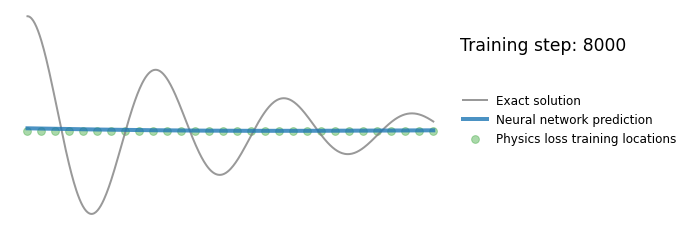

boundary physics loss tensor(0.9654, grad_fn=<SqueezeBackward0>) tensor(0.0147, grad_fn=<MulBackward0>)


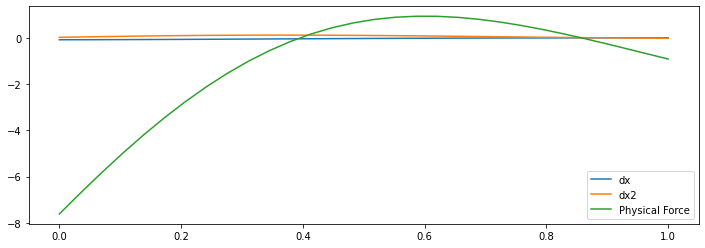

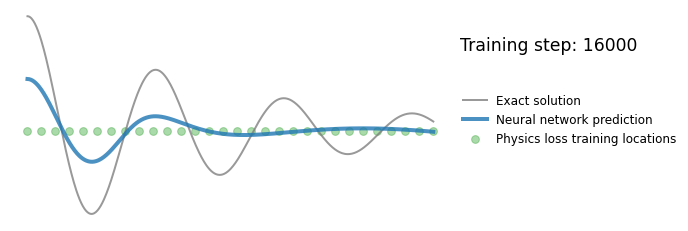

boundary physics loss tensor(0.3015, grad_fn=<SqueezeBackward0>) tensor(0.2231, grad_fn=<MulBackward0>)


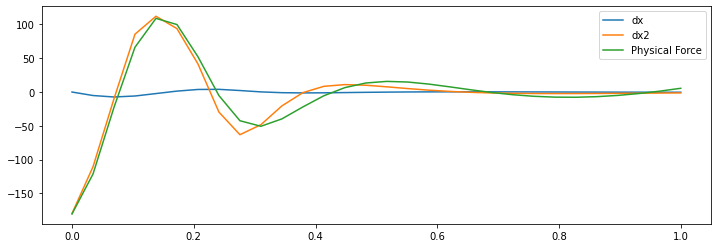

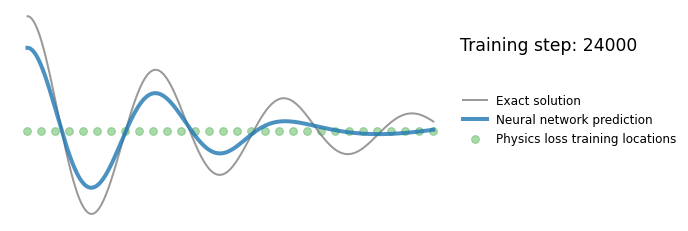

boundary physics loss tensor(0.0764, grad_fn=<SqueezeBackward0>) tensor(0.1614, grad_fn=<MulBackward0>)


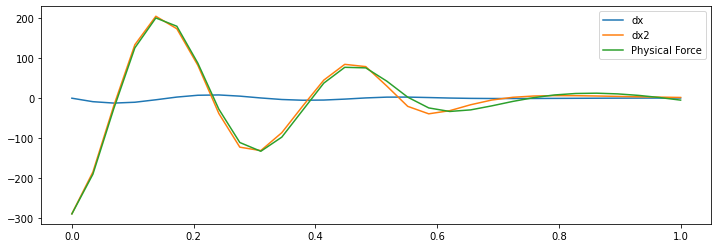

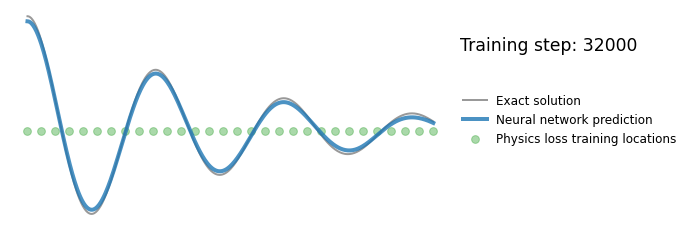

boundary physics loss tensor(0.0020, grad_fn=<SqueezeBackward0>) tensor(0.0174, grad_fn=<MulBackward0>)


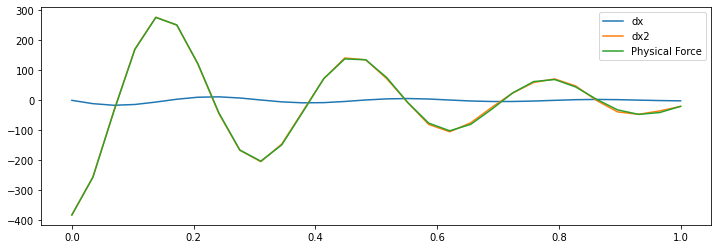

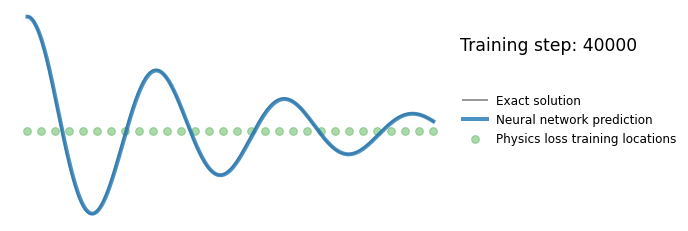

boundary physics loss tensor(0.0002, grad_fn=<SqueezeBackward0>) tensor(0.0032, grad_fn=<MulBackward0>)


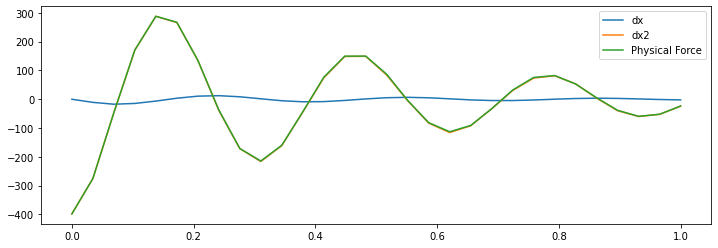

In [7]:
figs=[]
losses, model = train_oscillator(2e-3)

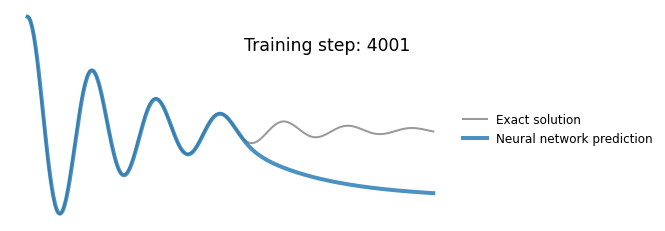

In [8]:
x = torch.linspace(0,2,500).view(-1,1)
y = oscillator(d, w0, x).view(-1,1)
y_nn = model(x).detach()
plot_result(x,y,y_nn, 4000)

In [9]:
!pip install pykan

## Using KAN instead of MLP

In [10]:
from kan import KAN


x = torch.linspace(0,1,500).view(-1,1)
y = oscillator(d, w0, x).view(-1,1)
x_physics = torch.linspace(0,1,25).view(-1,1).requires_grad_(True)# sample locations over the problem domain
x_boundary = torch.tensor([[0.0]]).requires_grad_(True)
mu, k = 2*d, w0**2

physics_weight = 1e-3
model = KAN(width=[1,4,1], grid=5, k=3, grid_eps=1.0, noise_scale_base=0.25)
model.update_grid_from_samples(x_physics)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-2)
# optimizer = LBFGS(model.parameters(), lr=1, history_size=10, line_search_fn="strong_wolfe", tolerance_grad=1e-32, tolerance_change=1e-32, tolerance_ys=1e-32)
files = []
epochs=1000
# steps = 20
# pbar = tqdm(range(steps), desc='description')
losses = dict(boundaryloss=[], physicsloss=[])

for i in range(epochs):
    optimizer.zero_grad()
    # compute the "physics loss"
    yhp = model(x_physics)
    dx  = torch.autograd.grad(yhp, x_physics, torch.ones_like(yhp), create_graph=True)[0]# computes dy/dx
    dx2 = torch.autograd.grad(dx,  x_physics, torch.ones_like(dx),  create_graph=True)[0]# computes d^2y/dx^2
    physics = dx2 + mu*dx + k*yhp# computes the residual of the 1D harmonic oscillator differential equation
    physicsloss = physics_weight*torch.mean(physics**2)
    y_boundary = model(x_boundary)
    dx_boundary = torch.autograd.grad(y_boundary, x_boundary, torch.ones_like(y_boundary), create_graph=True)[0]
    boundaryloss = torch.squeeze((y_boundary-1.0)**2 + dx_boundary**2)

    # backpropagate joint loss
    loss = boundaryloss + physicsloss# add two loss terms together
    loss.backward()
    optimizer.step()
    losses["boundaryloss"].append(boundaryloss.detach().item())
    losses["physicsloss"].append(physicsloss.detach().item())


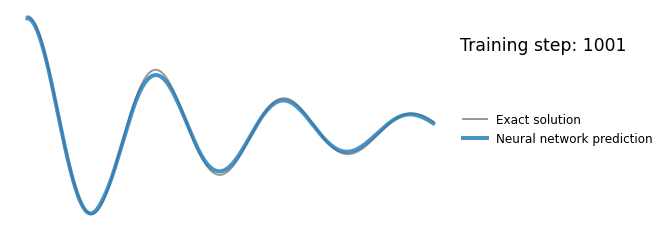

In [11]:
x = torch.linspace(0,1,500).view(-1,1)
y = oscillator(d, w0, x).view(-1,1)
y_nn = model(x).detach()
plot_result(x,y,y_nn, 1000)

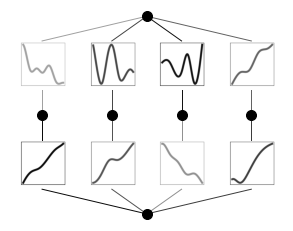

In [12]:
model.plot()